# Comparer l'impact sur le rendement lorsque le nombre total d'actions dans le portefeuille est différent. 

## 1.Préparation de la BD

In [1]:
import numpy as np
import numpy.linalg as cm
import pandas as pd
import glob
import numpy.random as npr
import matplotlib.pyplot as plt

# contenu de excel : "Actif","Date","Ouverture","Max","Min","Fermeture","Volume"
# tous les actions que on a utiliser en cours Finance marché 2 (12 actions)
file_list_actions = glob.glob("actions/*.xlsm")

# tous les actions que on a trouver en ligne (18 actions)
file_list_new_action = [
    file for file in glob.glob("new actions/*.xlsm") if "CAC40" not in file
]

file_list_6 = file_list_actions[:6]
file_list_12= file_list_actions
file_list_18 = file_list_actions + file_list_new_action[:6]
file_list_24 = file_list_actions + file_list_new_action[:12]
file_list_30 = file_list_actions + file_list_new_action   

BD_dict = {
    "BD6": [pd.read_excel(file, engine="openpyxl") for file in file_list_actions[:6]],
    "BD12": [pd.read_excel(file, engine="openpyxl") for file in file_list_12],
    "BD18": [pd.read_excel(file, engine="openpyxl") for file in file_list_actions + file_list_new_action[:6]],
    "BD24": [pd.read_excel(file, engine="openpyxl") for file in file_list_actions + file_list_new_action[:12]],
    "BD30": [pd.read_excel(file, engine="openpyxl") for file in file_list_actions + file_list_new_action]
}


## 2.Calcul du SIGMA et de l'ER

In [2]:
def compute_statistics(BD):
    
    """
    selon les données de BD, on calcule les statistiques suivantes:
    - ER: vecteur de rendement moyen
    - SIGMA: matrice de covariance des rendements
    - déterminant de SIGMA & matrice inverse
    - a, b, norm, valsigma, etc.
    """
     
    lengthBD = len(BD)
   # -----------------------------
    # 1. calculer ER
    # -----------------------------
    ER = np.ones((lengthBD, 1))
    for j in range(lengthBD):
        bd = BD[j]
        St = [
            (bd.iloc[i, 3] + bd.iloc[i, 4]) / 2 for i in range(min(255,len(bd)))
        ]  # St est le prix moyen de chaque action
        Rt = [
            (St[i + 1] / St[i]) - 1 for i in range(min(254,len(bd)-1))
        ]  # Rt est le rendement de chaque action
        ER[j] = np.mean(Rt)  # ER[j] est le rendement moyen de l'action j
    # -----------------------------
    # 2. calculer SIGMA(matrice de covariance)
    # -----------------------------
    SIGMA = np.ones((lengthBD, lengthBD))
    for i in range(lengthBD):
        for j in range(lengthBD):
            bdi = BD[i]
            Sti = [(bdi.iloc[k, 3] + bdi.iloc[k, 4]) / 2 for k in range(min(255,len(bd)))]
            Rti = [
                (Sti[k + 1] / Sti[k]) - 1 for k in range(min(254,len(bd)-1))
            ]  # Rti est les rendements de l'action i
            RtiC = np.array(Rti) - ER[i]  # RtiC est le rendement de l'action i centré

            bdj = BD[j]
            Stj = [(bdj.iloc[k, 3] + bdj.iloc[k, 4]) / 2 for k in range(min(255,len(bd)))]
            Rtj = [
                Stj[k + 1] / Stj[k] - 1 for k in range(min(254,len(bd)-1))
            ]  # Rtj est le rendement de l'action j
            RtjC = np.array(Rtj) - ER[j]

            SIGMA[i, j] = np.mean(RtiC * RtjC)
 
    return ER, SIGMA

## 3.Calcul du meilleur x_opt 

In [3]:
def get_x_opt(NS,BDLength,Sigmax,ER,SIGMA):
    Espmax = -(10**10)  # initialisation le rendement maximal
    # initialisation du vecteur de poids optimal
    x_opt = np.array([1 for _ in range(BDLength)])
    for _ in range(NS):  # Monte Carlo 迭代
            # générer un vecteur de poids aléatoires
            x = [npr.uniform() for _ in range(BDLength)]  # uniforme sur [0, 1]
            x = np.array(x)  # convertir en tableau numpy
            s = np.sum(x)  # somme des poids
           
             #  pas égal à 0
            if s == 0:
                x[0] = 1  # si la somme des poids est nulle, on met le premier poids à 1
            else:
                x = x / s  # normaliser les poids

            var = x.T @ SIGMA @ x
            sig = np.sqrt(var)
            esp = x.T @ np.squeeze(ER)
            
            # vérifier si la contrainte de risque est satisfaite
            if sig <= Sigmax:
            # vérifier si le rendement est supérieur à l'ancien rendement maximal
                if esp > Espmax:
                    Espmax = esp  # mettre à jour le rendement maximal
                    x_opt = x  # mettre à jour le vecteur de poids optimal
    return x_opt,Espmax

## 4. Calcul des 𝑋_opt et des rendements selon les risques maximales acceptées, puis création d'une image

In [4]:
def get_x_opt_Esp_list(NS, BDLength, ER, SIGMA, valsigma):
    Esp_list = []  
    x_opt_list = []  

    for sig_target in valsigma:  
        x_opt,Espmax=get_x_opt(NS,BDLength,sig_target,ER,SIGMA)
        Esp_list.append(Espmax)
        x_opt_list.append(x_opt)

    return x_opt_list, np.array(Esp_list)  

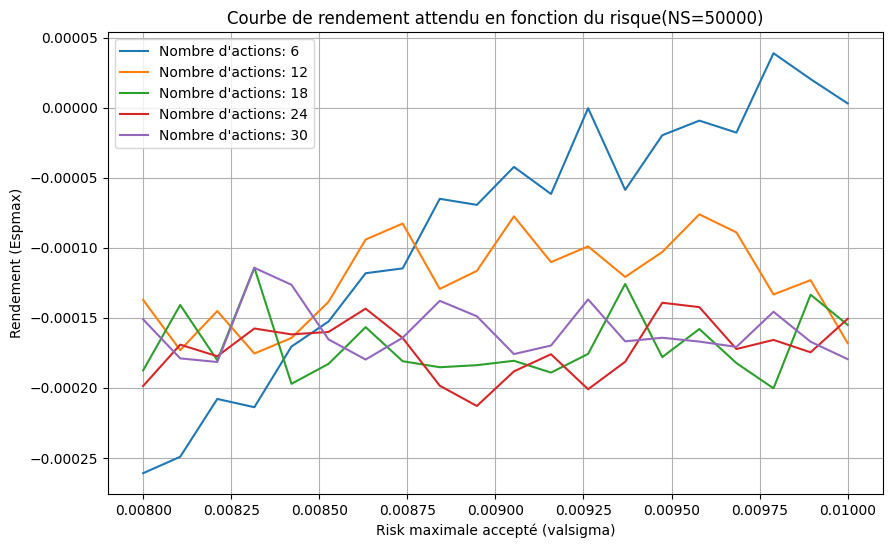

In [5]:

NS = 50000
BD_results = {}
valsigma = np.linspace(0.008, 0.01, 20)

for BD_name, BD in BD_dict.items():
    ER, SIGMA= compute_statistics(BD)
    x_opt,Esp_list = get_x_opt_Esp_list(NS, len(BD), ER, SIGMA, valsigma)  
    BD_results[BD_name] = (valsigma, Esp_list)

plt.figure(figsize=(10, 6))
for BD_name, (valsigma, Esp_list) in BD_results.items():
    plt.plot(valsigma, Esp_list, label=f"Nombre d'actions: {BD_name[2:]}")  

plt.xlabel("Risk maximale accepté (valsigma)")
plt.ylabel("Rendement (Espmax)")
plt.title(f"Courbe de rendement attendu en fonction du risque(NS={NS})")
plt.legend()
plt.grid()
plt.show()


## 5.Calculer du capital final à la fin de 2019

In [6]:

def filter_2019(BD):
    BD2019 = []
    for df in BD:
        df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], format="%d/%m/%Y")  
        BD2019.append(df[df.iloc[:, 1].dt.year == 2019]) 
    return BD2019


def cal_theta_cash_fee(C, x_opt, St, k, old_theta):
    theta = np.array([int(C * x_opt[i] / St[i]) for i in range(len(St))])
    fee = np.abs(theta - old_theta).T @ St * k  
    cash = C - theta.T @ St - fee
    C_available = C
    while cash < 0:  
        C_available -= 1
        theta = np.array([int(C_available * x_opt[i] / St[i]) for i in range(len(St))])
        fee = np.abs(theta - old_theta).T @ St * k
        cash = C - theta.T @ St - fee
    return theta, cash, fee


def test_strategy_with_k(C, x_opt, S, k, freq=1):
    Cs = [C]
    S0 = np.array([S[i][0] for i in range(len(S))])
    theta, cash, fee = cal_theta_cash_fee(C, x_opt, S0, k, np.zeros(len(S), dtype=int))
    fees = [fee]

    for t in range(1, len(S[0])):  
        St = np.array([S[i][t] for i in range(len(S))])
        C = cash + theta.T @ St  
        Cs.append(C)

        if t % freq == 0:  
            theta, cash, fee = cal_theta_cash_fee(C, x_opt, St, k, theta)
            fees.append(fee)
        else:
            fees.append(0)

    return Cs, fees



### 5.a） quand il y a des coûts de transaction 

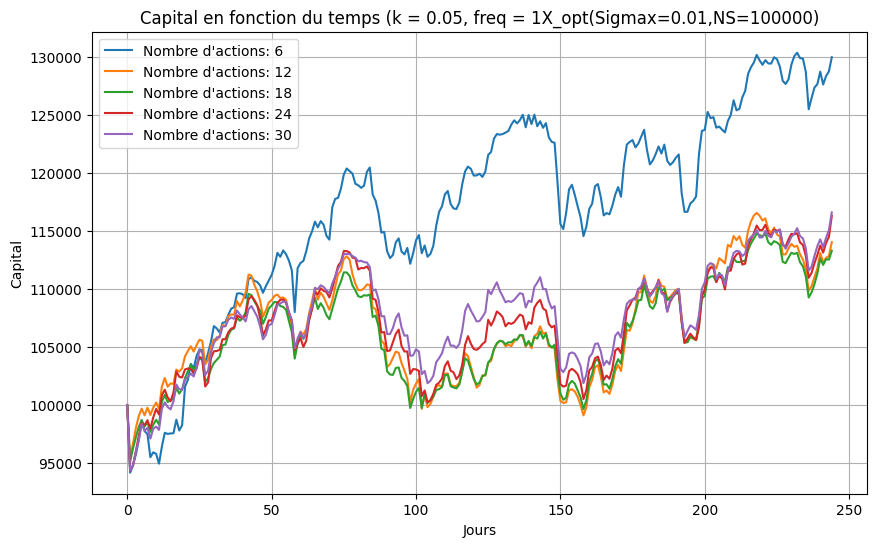

In [ ]:
C = 100000  
k = 0.05  
freq = 1  
NS = 100000  
Sigmax = 0.01  

Ct_results = {}


for BD_name, BD in BD_dict.items():
    BD2019 = filter_2019(BD)  

    S = [[(df.iloc[j, 3] + df.iloc[j, 4]) / 2 for j in range(len(df))] for df in BD2019]


    ER, SIGMA= compute_statistics(BD2019)


    # NS = 10000, Sigmax = 0.01, on trouvera le rendement maximal
    x_opt,_=get_x_opt(10000,len(BD2019),0.01,ER,SIGMA)


    Cs, _ = test_strategy_with_k(C, x_opt, S, k, freq)

    Ct_results[BD_name] = Cs

plt.figure(figsize=(10, 6))
for BD_name, Cs in Ct_results.items():
    plt.plot(Cs, label=f"Nombre d'actions: {BD_name[2:]}")

plt.xlabel("Jours")
plt.ylabel("Capital")
plt.title(f"Capital en fonction du temps (k = {k}, freq = 1X_opt(Sigmax={Sigmax},NS={NS})")
plt.legend()
plt.grid()
plt.show()


### 5.b） quand il n‘y a pas de coûts de transaction 

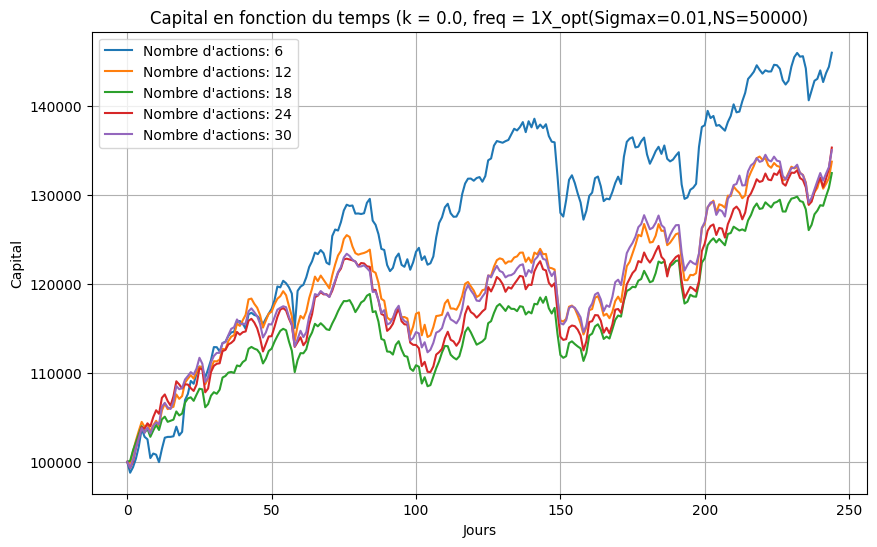

In [9]:
C = 100000  
k = 0.00  
freq = 1  
NS = 50000
Sigmax = 0.01  

Ct_results = {}


for BD_name, BD in BD_dict.items():
    BD2019 = filter_2019(BD)  

    S = [[(df.iloc[j, 3] + df.iloc[j, 4]) / 2 for j in range(len(df))] for df in BD2019]


    ER, SIGMA= compute_statistics(BD2019)


    # NS = 10000, Sigmax = 0.01, on trouvera le rendement maximal
    x_opt,_=get_x_opt(10000,len(BD2019),0.01,ER,SIGMA)


    Cs, _ = test_strategy_with_k(C, x_opt, S, k, freq)

    Ct_results[BD_name] = Cs

plt.figure(figsize=(10, 6))
for BD_name, Cs in Ct_results.items():
    plt.plot(Cs, label=f"Nombre d'actions: {BD_name[2:]}")

plt.xlabel("Jours")
plt.ylabel("Capital")
plt.title(f"Capital en fonction du temps (k = {k}, freq = 1X_opt(Sigmax={Sigmax},NS={NS})")
plt.legend()
plt.grid()
plt.show()